In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

# Clear previous session
K.clear_session()

# Define image dimensions
img_height, img_width = 32, 32
batch_size = 32

# Create an ImageDataGenerator for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset/train',  # Change this to your training directory
    target_size=(img_height, img_width),  # Resize to 32x32
    color_mode='rgb',  # Convert to RGB
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset/train',  # Change this to your training directory
    target_size=(img_height, img_width),  # Resize to 32x32
    color_mode='rgb',  # Convert to RGB
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Test generator
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset/test',  # Change this to your testing directory
    target_size=(img_height, img_width),  # Resize to 32x32
    color_mode='rgb',  # Convert to RGB
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the VGG16 model with the new input shape
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')  # Set the number of output classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
# Define callbacks with adjusted patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Train the model with the updated callbacks
model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)


# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy*100:.2f}%')


Found 22 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5000 - loss: 0.7038 - val_accuracy: 0.5000 - val_loss: 0.7849 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step - accuracy: 0.5000 - loss: 0.7824 - val_accuracy: 0.2500 - val_loss: 0.7486 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step - accuracy: 0.5000 - loss: 0.7003 - val_accuracy: 0.5000 - val_loss: 0.7845 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step - accuracy: 0.5000 - loss: 0.7327 - val_accuracy: 0.5000 - val_loss: 0.8305 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step - accuracy: 0.5000 - loss: 0.7418 - val_accuracy: 0.5000 - val_loss: 0.6769 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4545 - loss: 0.7162 - val_accuracy: 0.7500 - val_loss: 0.6928 - learning_

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
              precision    recall  f1-score   support

           A       0.58      0.93      0.72        15
           B       0.75      0.23      0.35        13

    accuracy                           0.61        28
   macro avg       0.67      0.58      0.54        28
weighted avg       0.66      0.61      0.55        28



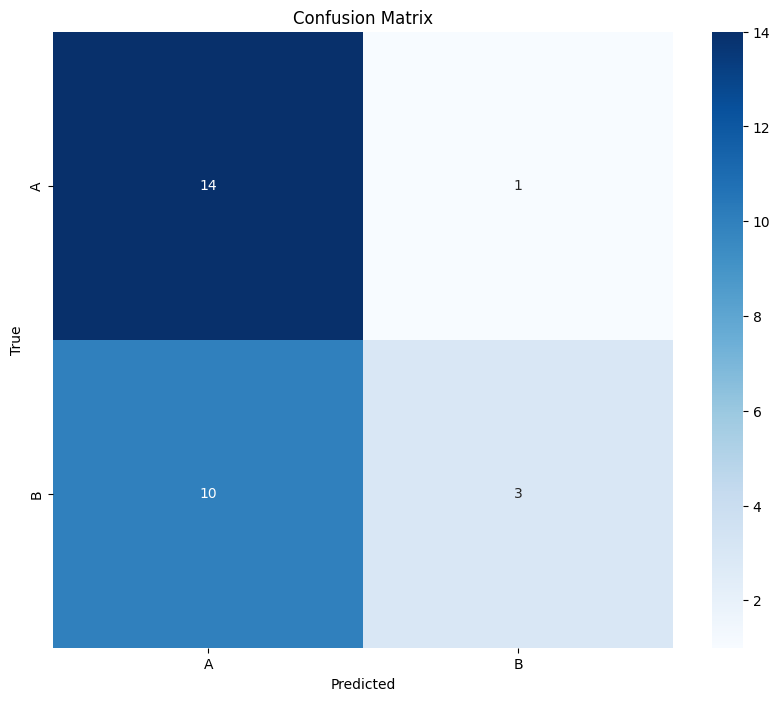

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generate predictions on the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)  # Get the class with highest probability

# Get the true labels from the test generator
true_labels = test_generator.classes  # Get true labels
class_names = test_generator.class_indices.keys()  # Get class names

# Print classification report
print(classification_report(true_labels, y_pred, target_names=class_names))

# Generate and plot confusion matrix
confusion_mtx = confusion_matrix(true_labels, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
